In [44]:
# ───────────────────────────────
# 📦 Standard Libraries
# ───────────────────────────────
import os
import sys
import math
import time
import csv
import pickle
from datetime import datetime, timedelta
from collections import Counter

# ───────────────────────────────
# 📚 Data Handling & Utilities
# ───────────────────────────────
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import h5py
from joblib import dump, load

# ───────────────────────────────
# 📊 Visualization
# ───────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns

# ───────────────────────────────
# 📈 Machine Learning
# ───────────────────────────────
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_curve, roc_auc_score, auc,
    classification_report, confusion_matrix
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.under_sampling import RandomUnderSampler

# ───────────────────────────────
# 🌍 Seismology & Signal Processing
# ───────────────────────────────
import obspy
from obspy import UTCDateTime
from obspy.geodetics.base import gps2dist_azimuth
from obspy.clients.fdsn import Client
from obspy.signal.filter import envelope
from scipy import stats, signal

# ───────────────────────────────
# 🔗 External Tools
# ───────────────────────────────
from zenodo_get import zenodo_get

# ───────────────────────────────
# 🤖 Deep Learning
# ───────────────────────────────
import torch
import torch.nn.functional as F
from neural_network_architectures import SeismicCNN_2d

# ───────────────────────────────
# 🛠 Custom Utilities
# ───────────────────────────────
sys.path.insert(0, '/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts')

from utils import (
    extract_waveforms,
    compute_spectrogram,
    normalize_spectrogram_minmax,
    return_train_val_loaders,
    plot_confusion_matrix_and_cr,
    train_model,
    WaveformPreprocessor
)

# Pandas display options
pd.set_option('display.max_columns', None)


sys.path.append('/home/ak287/seisbench/seisbench/models')
import seisbench.models as sbm



# for extracting unique stations
import re
from pathlib import Path

In [4]:
# Function to extract information
def extract_datetime_info(date_str):
    date_obj = datetime.strptime(date_str, '%Y_%m_%d %H%M%S')
    hour_of_day = date_obj.hour - 8
    day_of_week = date_obj.weekday()  # Full day name
    month_of_year = date_obj.month  # Full month name
    return hour_of_day, day_of_week, month_of_year



def conv_to_datetime(df):
    new_df = []
    for i in range(len(df)):
        year = int(df[i].split('_')[0])
        month = int(df[i].split('_')[1])
        day = int(df[i].split('_')[2].split(' ')[0])
        hour = int(df[i].split('_')[2].split(' ')[1][0:2])
        minute = int(df[i].split('_')[2].split(' ')[1][2:4])
        second = int(df[i].split('_')[2].split(' ')[1][4:])
        new_df.append(obspy.UTCDateTime(year, month, day, hour, minute, second))
        
    return np.array(new_df)

In [5]:
pd.set_option('display.max_columns', None)
cat_all = pd.read_csv('../../data/IRISExoticEventCatalog.txt', sep='|')
cat = cat_all.copy()
cat

,areaSource,areaSourceHigh,areaSourceLow,areaTotal,associationId,datlocation,depth,endtime,eventid,h,hHigh,hLow,hfall,hfall_high,hfall_low,l,lHigh,lLow,latitude,locuncertKm,longitude,lppotential,mass,massHigh,massLow,maxdistvhfKm,maxdistvhfReached,maxdisthfKm,maxdisthfReached,maxdistipKm,maxdistipReached,maxdistlpKm,maxdistlpReached,maxdistinfraKm,maxdistinfraReached,infraDetected,name,otherdataquality1to5,peakDischarge,peakDischargeLow,peakDischargeHigh,peakFlowheight,peakFlowheightLow,peakFlowheightHigh,starttime,sources,toeLat,toeLon,topLat,topLon,upstreamDrainarea,type,subtype,volume,volumeHigh,volumeLow
0,NaN,NaN,NaN,NaN,22,IRIS,NaN,2007_07_25 010251,22,1860.0,NaN,NaN,NaN,NaN,NaN,5760.0,NaN,NaN,61.10249,0.00,-140.30550,1,1.080000e+11,NaN,NaN,NaN,NaN,1079.0,True,NaN,NaN,1100.0,False,NaN,NaN,NaN,Mount Steele 2,5,NaN,NaN,NaN,NaN,NaN,NaN,2007_07_25 005835,"Allstadt, Kate E., McVey, Brennah G., and Malo...",61.14054,-140.25324,61.10249,-140.30550,NaN,rock and ice avalanche,Rock/ice/debris avalanches and slides,54000000.0,80500000.0,27500000.0
1,NaN,NaN,NaN,NaN,218,"RESIF, ETH, ORFEUS, LMU, BGR, IRIS, INGV",NaN,2017_08_23 093828,218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.29552,NaN,9.60190,0,NaN,NaN,NaN,NaN,NaN,246.0,False,NaN,NaN,0.0,NaN,NaN,NaN,NaN,"Piz Cengalo 4, Switzerland",1,NaN,NaN,NaN,NaN,NaN,NaN,2017_08_23 093617,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",NaN,NaN,NaN,NaN,NaN,landslide,Rock/ice/debris avalanches and slides,NaN,NaN,NaN
2,111000.0,NaN,NaN,1130000.0,127,IRIS,NaN,2017_07_22 205957,127,931.0,NaN,NaN,NaN,NaN,NaN,3730.0,NaN,NaN,60.07385,0.00,-139.84532,1,NaN,NaN,NaN,NaN,NaN,351.0,False,NaN,NaN,386.0,False,0.0,NaN,False,Lucia Glacier,4,NaN,NaN,NaN,NaN,NaN,NaN,2017_07_22 205630,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",60.06616,-139.90755,60.07385,-139.84532,NaN,rock avalanche,Rock/ice/debris avalanches and slides,3000000.0,4000000.0,2300000.0
3,100000.0,150000.0,65000.0,820000.0,186,"IRIS, NCEDC",NaN,2013_07_25 101727,186,690.0,760.0,640.0,NaN,NaN,NaN,2000.0,2100.0,1600.0,61.98450,0.00,-143.16830,1,4.000000e+10,NaN,NaN,NaN,NaN,500.0,False,NaN,NaN,500.0,False,NaN,NaN,NaN,Wrangell Mountains,4,NaN,NaN,NaN,NaN,NaN,NaN,2013_07_25 101456,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",61.97220,-143.14950,61.98450,-143.16830,NaN,rock and debris avalanche,Rock/ice/debris avalanches and slides,2600000.0,3900000.0,1800000.0
4,23400.0,NaN,NaN,NaN,147,IRIS,NaN,2019_05_13 144245,147,1240.0,NaN,NaN,NaN,NaN,NaN,4320.0,NaN,NaN,50.34480,0.00,-122.45110,1,NaN,NaN,NaN,NaN,NaN,391.0,True,NaN,NaN,301.0,True,NaN,NaN,NaN,Mount Joffre 1,5,NaN,NaN,NaN,NaN,NaN,NaN,2019_05_13 143955,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",50.36720,-122.41540,50.34480,-122.45110,NaN,"rock avalanche, debris flow",Rock/ice/debris avalanches and slides,1900000.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,NaN,NaN,NaN,NaN,185,Attachments below,NaN,2015_06_09 160558,185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.67199,NaN,10.72268,0,NaN,NaN,NaN,3.0,NaN,3.0,True,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Gadria 3,5,27.0,NaN,NaN,1.7,NaN,NaN,2015_06_09 151558,"Coviello, V., Arattano, M., Comiti, F., Maccon...",NaN,NaN,NaN,NaN,6.3,debris flow,Lahar/debris flow/outburst flood,12600.0,NaN,NaN
241,310000.0,520000.0,200000.0,7900000.0,19,IRIS,NaN,2012_06_11 222652,19,2400.0,2500.0,2300.0,NaN,NaN,NaN,9300.0,9500.0,9100.0,58.79367,0.00,-137.44247,1,2.000000e+10,NaN,NaN,NaN,NaN,890.0,True,NaN,NaN,1000.0,False,NaN,NaN,NaN,Mount Lituya main,4,NaN,NaN,NaN,NaN,NaN,NaN,2012_06_11 222400,"Allstadt, Kate E., McVey, Brennah G., and Malo...",58.81626,-137.30032,58.79367,-137.44247,NaN,rock and ice avalanche,Rock/ice/debris avalanches and slides,13000000.0,60000000.0,2800000.0
242,130000.0,160000.0,84000.0,3000000.0,188,"IRIS, NCEDC",NaN,2010_07_09 073820,188,1800.0,1900.0,

In [6]:
event_ids = cat['eventid'].values
source_types = cat['type'].values
source_subtypes = cat['subtype'].values

In [7]:
hod = [extract_datetime_info(i)[0] for i in cat['starttime'].values]
dow = [extract_datetime_info(i)[1] for i in cat['starttime'].values]
moy = [extract_datetime_info(i)[2] for i in cat['starttime'].values]

In [8]:
## computing the durations
sttime = cat['starttime']
ettime = cat['endtime']

starttimes = conv_to_datetime(sttime)
endtimes = conv_to_datetime(ettime)
dur = conv_to_datetime(ettime) - conv_to_datetime(sttime)

In [9]:
st_z = []
st_data = []
evids = []
hod_trace = []
dow_trace = []
moy_trace = []
event_types = []
event_subtypes = []
event_duration = []
trids = []


for i in tqdm(range(len(event_ids))):
    try:
        files = glob("../../data/iris_esec_waveforms/waveforms/"+str(event_ids[i])+'/*HZ*')
        for file in files:
            tr = obspy.read(file)
            tr = tr.detrend(type = 'linear')
            d = tr[0].resample(100).data
            
            ## We are going to test the ml_40 model (so we will use P-10, P+30)
            data = d[8500:12500]
            snr = np.nanmax(abs(data))/np.nanmean(abs(data))

            if snr > 5:
                st_data.append(data)
                evids.append(event_ids[i])           
                trids.append(tr[0].id)
                hod_trace.append(hod[i])
                dow_trace.append(dow[i])
                moy_trace.append(moy[i])
                event_types.append(source_types[i])
                event_subtypes.append(source_subtypes[i])
                event_duration.append(dur[i])
                
    except:
        pass
    

100%|██████████| 245/245 [00:52<00:00,  4.69it/s]


In [10]:
data

array([115.12102129, 120.3695389 , 142.87197234, ..., 202.8469757 ,
       173.34259434, 177.34490723])

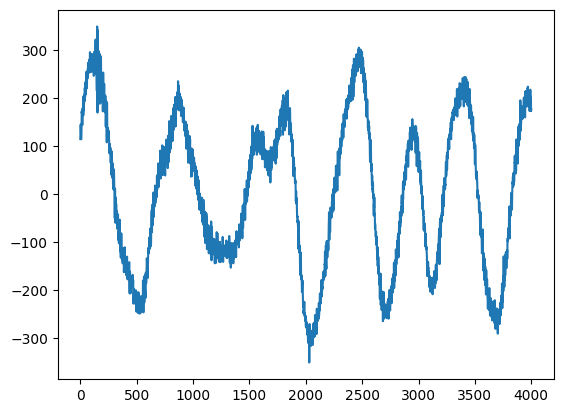

In [11]:
plt.plot(data)

## Loading the trained model

In [14]:
## setting up some important parameters (not to be changed)
num_channels = 3
dropout = 0.9
# Check if a GPU is available
device = "cuda"



model_quakexnet_2d = SeismicCNN_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available

# Load the saved model state dict (weights)
saved_model_quakexnet_2d = torch.load('../trained_models/best_model_new_augmented_SeismicCNN_2d.pth', map_location=torch.device('cpu'))  # No 'weights_only' argument
model_quakexnet_2d.load_state_dict(saved_model_quakexnet_2d)
model_quakexnet_2d.to(device)
model_quakexnet_2d.eval()


model = model_quakexnet_2d
model.to('cuda')


SeismicCNN_2d(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=15360, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.9, inplace=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2_bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

## No processing just loading the data here

In [14]:
st_data = []
evids = []
hod_trace = []
dow_trace = []
moy_trace = []
snr_trace_z = []
event_types = []
event_subtypes = []
event_duration = []
trids = []

for i in tqdm(range(len(event_ids))):
    try:
        
        # Find all three-component waveforms for this event
        files = glob(f"../../data/iris_esec_waveforms/waveforms/{event_ids[i]}/*H*")
        
        
        # Dictionary to group traces by station
        station_data = {}

        
        for file in files:
            tr = obspy.read(file)
            tr = tr.detrend(type='linear')
            d = tr[0].resample(50).data
            
            data = d[:13500]  # Extract P-10 to P+30 (assuming 50 Hz sampling)
            snr = np.nanmax(abs(data)) / np.nanmean(abs(data))

            if snr > 1:
                station = tr[0].stats.station
                channel = tr[0].stats.channel
                key = (event_ids[i], station)  # Group by event and station
                
                if key not in station_data:
                    station_data[key] = {}

                station_data[key][channel] = data  # Store by channel

        # Process each station
        for key, traces in station_data.items():
            if len(traces) == 3:  # Ensure three-component data exists
                sorted_channels = sorted(traces.keys())  # Ensure order is consistent
                stacked_data = np.stack([traces[ch] for ch in sorted_channels])  # Shape (3, 4000)

                st_data.append(stacked_data)  # Append in shape (3, 4000)
                evids.append(key[0])  # Event ID
                trids.append(key[1])  # Station ID
                hod_trace.append(hod[i])
                dow_trace.append(dow[i])
                moy_trace.append(moy[i])
                
                event_types.append(source_types[i])
                event_subtypes.append(source_subtypes[i])
                event_duration.append(dur[i])

    except Exception as e:
        print(f"Error processing event {event_ids[i]}: {e}")
        continue

# Convert to NumPy array
st_data = np.array(st_data)  # Final shape: (num_events, 3, 4000)


 46%|████▌     | 112/245 [00:55<02:20,  1.06s/it]/tmp/ipykernel_3708493/4101181955.py:29: RuntimeWarning: invalid value encountered in double_scalars
  snr = np.nanmax(abs(data)) / np.nanmean(abs(data))
100%|██████████| 245/245 [02:06<00:00,  1.94it/s]


## Computing the results of these waveforms - 

In [ ]:
probs_array = []
taper_alpha = 0.1
lowcut = 1
highcut = 20
nyquist = 0.5 * 50  # Nyquist frequency (original sampling rate is 100 Hz)
low = lowcut / nyquist
high = highcut / nyquist
b, a = signal.butter(4, [low, high], btype='band')  # Bandpass filter coefficients
taper_alpha = 0.1
fs = 50







for i in tqdm(range(len(st_data))):
    data = st_data[i]

    # Parameters
    window_size = 5000  # 100s
    stride = 500   # 10s
    num_windows = (data.shape[1] - window_size) // stride + 1  # Compute the number of windows

    # Create windows
    windows = np.stack([data[:, i:i+window_size] for i in range(0, data.shape[1] - window_size + 1, stride)])



    tapered_data = np.array([np.multiply(signal.windows.tukey(windows.shape[-1], alpha=taper_alpha), row) for row in windows])
    filtered_data = np.array([signal.filtfilt(b, a, row) for row in tapered_data])
    norm = np.std(abs(filtered_data), axis=(1,2))
    norm = norm.reshape(-1, 1, 1)
    normalized_data = (filtered_data / norm)
    specs = extract_spectrograms(normalized_data)


    # Run classification
    with torch.no_grad():
        output = model(torch.Tensor(specs).to(device))
        softmax_probs = F.softmax(output, dim=1).cpu().numpy()

    probs_array.append(softmax_probs)


In [21]:
#model1 = sbm.QuakeXNetoneD.from_pretrained("base")
model2 = sbm.SeismicCNN.from_pretrained("base")

In [25]:
file_sample = glob('../../data/iris_esec_waveforms/waveforms/227/*A291A*')

In [28]:
st = []
for file in file_sample:
    st += obspy.read(file)
    
st = obspy.Stream(st)

In [33]:
arr = np.array(model2.annotate(st))

In [37]:
arr

array([[7.3844111e-01, 6.6509847e-06, 8.5157611e-05, 1.9520448e-05],
       [1.3945255e-01, 4.8533747e-07, 8.7788858e-04, 7.6727645e-08],
       [1.2205659e-01, 9.9999261e-01, 9.9896693e-01, 9.9997282e-01],
       [4.9787475e-05, 2.9052134e-07, 6.9998991e-05, 7.6376718e-06]],
      dtype=float32)

### The below code is going over each event id, extracting a list of unique stations, then going through each station and selecting the one with three components, then classifying them directly using seisbench. 

In [46]:
probs_global = {}

for event_id in tqdm(event_ids):
    file_list = glob(f'../../data/iris_esec_waveforms/waveforms/{event_id}/*')
    
    # Extract unique station codes
    station_codes = set()
    for f in file_list:
        fname = Path(f).name
        match = re.match(r"[A-Z0-9]+\.(\w+)", fname)
        if match:
            station_codes.add(match.group(1))

    stn_list = sorted(station_codes)
    
    for stn in stn_list:
        chn_list = glob(f'../../data/iris_esec_waveforms/waveforms/{event_id}/*{stn}*')

        # Continue only if exactly 3 components are found
        if len(chn_list) == 3:
            try:
                st = obspy.Stream()
                for chn in chn_list:
                    st += obspy.read(chn)
                
                # Optional: sort channels to ensure consistent order
                st.sort(['channel'])
                
                # Predict probabilities using model
                probs_windows = np.array(model2.annotate(st))
                
                # Store in dict
                probs_global[(event_id, stn)] = probs_windows

            except Exception as e:
                print(f"Error with event {event_id}, station {stn}: {e}")


100%|██████████| 245/245 [14:43<00:00,  3.61s/it] 


dict_items([((74, 'SLD'), array([[1.1779279e-08, 9.6870514e-05, 9.4314860e-03, 1.9489673e-07],
       [1.6242953e-05, 6.3201762e-04, 6.0673571e-01, 2.0892565e-05],
       [9.9947733e-01, 1.9720782e-02, 1.1530241e-03, 9.9995244e-01],
       [5.0646137e-04, 9.7955030e-01, 3.8267973e-01, 2.6454640e-05]],
      dtype=float32)), ((130, 'PLBC'), array([[3.1831150e-05, 2.5470706e-03, 2.4186069e-04, 1.5107123e-07],
       [1.0114930e-05, 9.6585178e-01, 1.3885897e-04, 3.8217272e-06],
       [9.9878877e-01, 9.0147341e-03, 9.9950016e-01, 9.9991000e-01],
       [1.1693522e-03, 2.2586428e-02, 1.1912221e-04, 8.6067994e-05]],
      dtype=float32)), ((130, 'SKAG'), array([[3.4261220e-07, 2.1579124e-05, 1.9646272e-06, 7.6806181e-08],
       [2.0212319e-06, 2.5716657e-02, 3.6466558e-05, 1.1962911e-06],
       [9.9969840e-01, 1.6026139e-03, 9.9582714e-01, 9.9994683e-01],
       [2.9918889e-04, 9.7265911e-01, 4.1343705e-03, 5.1804716e-05]],
      dtype=float32)), ((130, 'YKU2'), array([[8.8112319e-01, 1.5

In [56]:
def process_probabilities(probs_dict, threshold=0.3):
    rows = []
    for (event_id, station), prob_array in probs_dict.items():
        print(prob_array)
        prob_eq = prob_array[0,0].mean()
        prob_px = prob_array[0,1].mean()
        prob_noise = prob_array[0,2].mean()
        prob_su = prob_array[0, 3].mean()

        max_prob = max(prob_eq, prob_px, prob_su)
        if max_prob > threshold:
            if max_prob == prob_eq:
                label = 'eq'
            elif max_prob == prob_px:
                label = 'px'
            else:
                label = 'surface'
        else:
            label = 'noise'

        rows.append({
            'event_id': event_id,
            'station': station,
            'prob_eq': prob_eq,
            'prob_px': prob_px,
            'prob_noise': prob_noise,
            'prob_surface': prob_su,
            'max_prob': max_prob,
            'assigned_label': label
        })

    return pd.DataFrame(rows)


In [57]:
# Example usage:
df = process_probabilities(probs_global)
df.head()

[[1.1779279e-08 9.6870514e-05 9.4314860e-03 1.9489673e-07]
 [1.6242953e-05 6.3201762e-04 6.0673571e-01 2.0892565e-05]
 [9.9947733e-01 1.9720782e-02 1.1530241e-03 9.9995244e-01]
 [5.0646137e-04 9.7955030e-01 3.8267973e-01 2.6454640e-05]]
[[3.1831150e-05 2.5470706e-03 2.4186069e-04 1.5107123e-07]
 [1.0114930e-05 9.6585178e-01 1.3885897e-04 3.8217272e-06]
 [9.9878877e-01 9.0147341e-03 9.9950016e-01 9.9991000e-01]
 [1.1693522e-03 2.2586428e-02 1.1912221e-04 8.6067994e-05]]
[[3.4261220e-07 2.1579124e-05 1.9646272e-06 7.6806181e-08]
 [2.0212319e-06 2.5716657e-02 3.6466558e-05 1.1962911e-06]
 [9.9969840e-01 1.6026139e-03 9.9582714e-01 9.9994683e-01]
 [2.9918889e-04 9.7265911e-01 4.1343705e-03 5.1804716e-05]]
[[8.8112319e-01 1.5005894e-06 1.5883536e-05 9.5894575e-01]
 [6.8168581e-02 2.1466140e-05 1.3459833e-05 2.9786965e-02]
 [5.0014615e-02 9.9990475e-01 9.9987471e-01 1.1263493e-02]
 [6.9368782e-04 7.2284318e-05 9.5914656e-05 3.8208937e-06]]
[[3.2990403e-05 7.7089778e-04 2.1387423e-05 1.572237

[[3.1976990e-02 3.9875700e-05 8.5119335e-03 1.0524234e-04 4.9831058e-05]
 [9.6414554e-01 5.2349533e-05 5.5587524e-01 2.4677576e-03 5.0604198e-05]
 [3.4373438e-03 7.9478645e-01 3.6524872e-03 9.9455380e-01 9.9917126e-01]
 [4.4014235e-04 2.0512135e-01 4.3196025e-01 2.8731704e-03 7.2840380e-04]]
[[8.0377032e-07 2.7866150e-05 1.5684624e-03 1.1448001e-05]
 [3.0480533e-06 5.1765604e-04 1.2235572e-01 1.1276182e-03]
 [9.9963236e-01 4.4549754e-04 9.7340653e-03 9.9805033e-01]
 [3.6385935e-04 9.9900889e-01 8.6634177e-01 8.1061706e-04]]
[[1.9567794e-06 1.4624806e-06 2.3099687e-06 2.3804678e-06 8.5872529e-07]
 [7.2852512e-05 2.3098573e-05 1.6335220e-03 1.3463055e-04 1.7193654e-06]
 [9.9559069e-01 9.9967635e-01 9.9227059e-01 9.9968922e-01 9.9997568e-01]
 [4.3345541e-03 2.9907731e-04 6.0935975e-03 1.7376308e-04 2.1739344e-05]]
[[6.0356706e-03 3.2225465e-03 1.1266560e-03 6.1191968e-04 1.9669817e-05]
 [5.4715478e-01 3.8828816e-02 9.5522672e-01 9.2116736e-02 1.5081106e-04]
 [4.4442165e-01 4.9325022e-01 2

[[2.42513652e-05 3.57706519e-03 7.28185929e-04 3.38195804e-07
  9.15734796e-04]
 [6.89886034e-01 3.70005280e-01 1.41272694e-01 4.88537480e-05
  3.11003514e-02]
 [2.99316227e-01 1.06770815e-02 8.50539148e-01 9.99399543e-01
  9.17146385e-01]
 [1.07734520e-02 6.15740538e-01 7.46000139e-03 5.51292964e-04
  5.08374348e-02]]
[[7.7762879e-02 2.3123880e-06 3.2375479e-07 5.6951785e-06]
 [8.8608027e-01 1.4208767e-05 1.3294172e-05 1.7360893e-05]
 [1.8802691e-02 9.9769503e-01 9.9995410e-01 9.9982637e-01]
 [1.7354060e-02 2.2883890e-03 3.2252337e-05 1.5063157e-04]]
[[6.6294018e-03 1.7802604e-06 3.9554420e-03 7.2067866e-07 1.1622961e-06]
 [9.4547749e-01 4.6853835e-05 2.4380372e-01 1.8072026e-06 8.6456180e-07]
 [1.1134477e-02 9.8545223e-01 1.7588757e-02 9.9996722e-01 9.9998701e-01]
 [3.6758672e-02 1.4499085e-02 7.3465210e-01 3.0254459e-05 1.0942660e-05]]
[[8.16833449e-07 3.88907403e-01 2.09853525e-07 1.36129307e-02]
 [2.80949530e-06 1.20463185e-02 6.39517680e-07 1.05805648e-05]
 [9.99982119e-01 5.3517

[[3.9598842e-07 4.0362045e-02 1.1969543e-08 1.3598020e-05]
 [1.6814018e-06 8.3953941e-01 1.1787255e-06 3.4396220e-03]
 [9.6786392e-01 7.5807251e-02 9.9998999e-01 5.2868909e-01]
 [3.2133989e-02 4.4291317e-02 8.8381157e-06 4.6785772e-01]]
[[1.7847080e-02 2.2102727e-03 9.3714794e-04 3.7442967e-03]
 [2.4442239e-02 5.3874659e-03 1.0939696e-03 2.8526864e-03]
 [2.7894270e-01 2.2356274e-02 8.7692475e-01 5.5970009e-03]
 [6.7876792e-01 9.7004592e-01 1.2104401e-01 9.8780602e-01]]
[[7.6331264e-05 1.0858977e-04 2.0028267e-05 4.9115602e-06]
 [3.1123287e-05 7.1053176e-07 2.1915200e-06 6.6254456e-06]
 [9.9985862e-01 9.9987519e-01 9.9997151e-01 9.9998474e-01]
 [3.3856257e-05 1.5441688e-05 6.3290422e-06 3.7495793e-06]]
[[5.9542035e-06 5.0557972e-08 5.0175192e-08 1.9962972e-05]
 [1.6532903e-06 4.6381311e-07 8.1387992e-07 1.4075398e-06]
 [9.9999237e-01 9.9999905e-01 9.9999797e-01 9.9997520e-01]
 [2.4094018e-09 5.3456347e-07 1.1789789e-06 3.5008700e-06]]
[[7.5764977e-04 4.6884274e-05 1.1186553e-02 1.066224

,event_id,station,prob_eq,prob_px,prob_noise,prob_surface,max_prob,assigned_label
0,74,SLD,1.177928e-08,0.000097,0.009431,1.948967e-07,0.000097,noise
1,130,PLBC,3.183115e-05,0.002547,0.000242,1.510712e-07,0.002547,noise
2,130,SKAG,3.426122e-07,0.000022,0.000002,7.680618e-08,0.000022,noise
3,130,YKU2,8.811232e-01,0.000002,0.000016,9.589458e-01,0.958946,surface
4,160,AUSB,3.299040e-05,0.000771,0.000021,1.572237e-05,0.000771,noise


In [ ]:
df